### 获取数据

In [12]:
# %load process.py
import numpy as np
import pandas as pd
import tushare as ts

class process_stock():

    def __init__(self, stock_list, token):
        self.stock_list = stock_list
        self.token = token
        ts.set_token(token)
        self.pro = ts.pro_api()
        
    def get_stock(self, name, market_type):
        '''
        日交易额单位：千元*N_amount

        Args:
            name: stock name
            market_type: nolimit or limit
        '''
        if market_type == 'nolimit':
            df = self.pro.daily(ts_code = name, start_date = self.start_date, end_date=self.end_date)
            df['yield_rate'] = df['change']/df['pre_close']
            df['abs_yield_rate'] = abs(np.log(df['close']/df['pre_close']))
            df['amihud'] = df['abs_yield_rate']/(df['amount']/self.N_amount)
            return df
        else:
            df = self.pro.daily(ts_code = name, start_date = self.start_date, end_date=self.end_date)
            df['yield_rate'] = df['change']/df['pre_close']
            df['max'] = df.apply(lambda x:max(x['pre_close'], x['high']), axis=1)
            df['min'] = df.apply(lambda x:min(x['pre_close'], x['low']), axis=1)
            df['abs_yield_rate'] = abs(np.log(df['max']/df['min']))
            df['amihud'] = df['abs_yield_rate']/(df['amount']/self.N_amount)
            return df
    

    
    def process_stock(self, name, df):
        '''
        '''
        df = df[['trade_date','yield_rate','amihud']]
        df.rename(columns={'yield_rate':'yield_rate_'+name, 'amihud':'amihud_'+name},inplace=True)
        return df

    def create_time_series(self, start_date, end_date, N_amount=1, market_type='nolimit'):
        '''
        获取 stock_list 中每只 stock 的 yield rate 以及 amihud 指标并得到时间序列
        
        Args:
            name: stock name
            start_date: trade start date
            end_date: trade end date
            N_amount: 成交额的单位
        '''
        # 先获取第一个
        self.start_date = start_date
        self.end_date = end_date
        self.N_amount = N_amount
        df = self.get_stock(self.stock_list[0], market_type)
        df = self.process_stock(self.stock_list[0], df)
        # 将第一个和后面的合并
        for i in range(len(self.stock_list)-1):
            df_temp = self.get_stock(self.stock_list[i+1], market_type)
            df_temp = self.process_stock(stock_list[i+1], df_temp)
            df = pd.merge(df,df_temp)
        self.df = df
        # 改变顺序
        row_list1 = ['trade_date']
        row_list2 = []
        for name in self.stock_list:
            row_list1.append('yield_rate_'+name)
            row_list2.append('amihud_'+name)
        self.df = self.df[row_list1+row_list2]
        self.df = self.df.dropna(axis=1, how='any')
        self.df = self.df.iloc[::-1]
        self.df['trade_date'] = pd.to_datetime(self.df['trade_date'])
        return self.df

    def save_df(self, path):
        '''
        保存为csv格式
        '''
        self.df.to_csv(path, index = False)
        


In [82]:
import tushare as ts
import numpy as np
import pandas as np
token = '094f15d71394516b730602faa77b1c708007b8d05df300590b4445ed'
ts.set_token(token)
pro=ts.pro_api()

In [13]:
stock_list = ['000001.SZ','600000.SH','600015.SH','600016.SH','600036.SH','601166.SH',
              '601288.SH','601328.SH','601398.SH','601818.SH',
              '601939.SH','601988.SH','601998.SH']

token = '094f15d71394516b730602faa77b1c708007b8d05df300590b4445ed'
process = process_stock(stock_list, token)

In [15]:
df = process.create_time_series('20180101','20191231', 1000, 'limit')
df

,trade_date,yield_rate_000001.SZ,yield_rate_600000.SH,yield_rate_600015.SH,yield_rate_600016.SH,yield_rate_600036.SH,yield_rate_601166.SH,yield_rate_601288.SH,yield_rate_601328.SH,yield_rate_601398.SH,...,amihud_600016.SH,amihud_600036.SH,amihud_601166.SH,amihud_601288.SH,amihud_601328.SH,amihud_601398.SH,amihud_601818.SH,amihud_601939.SH,amihud_601988.SH,amihud_601998.SH
486,2018-01-02,0.030075,0.010326,0.012222,0.015495,0.020675,0.014715,0.005222,0.011272,-0.003226,...,0.000033,0.000018,0.000010,0.000014,0.000029,0.000013,0.000036,0.000027,0.000018,0.000098
485,2018-01-03,-0.027007,-0.004717,0.002195,0.007042,0.011816,-0.002320,0.007792,0.003185,-0.003236,...,0.000019,0.000013,0.000006,0.000015,0.000028,0.000015,0.000024,0.000029,0.000021,0.000068
484,2018-01-04,-0.006002,0.000000,0.002191,-0.004662,-0.010677,-0.000581,-0.002577,-0.001587,-0.014610,...,0.000012,0.000021,0.000009,0.000013,0.000021,0.000007,0.000026,0.000020,0.000017,0.000082
483,2018-01-05,0.003774,0.002370,0.001093,0.007026,0.015177,0.000582,0.000000,-0.001590,0.001647,...,0.000014,0.000018,0.000006,0.000014,0.000016,0.000005,0.000028,0.000023,0.000014,0.000075
482,2018-01-08,-0.025564,-0.000788,0.003275,0.013953,-0.020930,0.001163,-0.002584,0.004777,-0.001645,...,0.000024,0.000014,0.000007,0.000014,0.000014,0.000007,0.000022,0.000028,0.000011,0.000046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2019-12-25,-0.006098,-0.003257,-0.005270,-0.004792,-0.005788,-0.007035,-0.002717,-0.001792,-0.005119,...,0.000031,0.000018,0.000019,0.000023,0.000025,0.000015,0.000093,0.000023,0.000037,0.000117
3,2019-12-26,0.010429,0.004085,0.005298,0.003210,0.008203,0.010121,0.010899,0.005386,0.005146,...,0.000031,0.000015,0.000020,0.000029,0.000032,0.000016,0.000070,0.000028,0.000037,0.000142
2,2019-12-27,0.009715,0.002441,0.005270,0.003200,-0.006299,0.000000,0.005391,0.003571,0.006826,...,0.000025,0.000013,0.000013,0.000017,0.000021,0.000020,0.000058,0.000020,0.000023,0.000114
1,2019-12-30,-0.003608,0.001623,0.002621,0.006380,-0.000792,-0.010020,-0.002681,0.003559,-0.001695,...,0.000037,0.000013,0.000012,0.000017,0.000024,0.000012,0.000058,0.000015,0.000028,0.000106


In [16]:
process.save_df(path='./stock2.csv')

### 时间序列数据处理

In [54]:
# %load var_lag_order.py
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.dates as mdate
from numpy import *
from matplotlib.pylab import rcParams
plt.rcParams['axes.unicode_minus']=False
rcParams['font.sans-serif'] = 'kaiti'

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.stats.diagnostic
from statsmodels.tsa.api import VAR


class var_lag_order():
    
    def __init__(self, data):
        '''
        '''
        self.row = data.shape[0]
        self.column = data.shape[1]
        self.initial_data = data
        # self.stationary_p_value = stationary_p_value


    def judge_percent(self, test):
        '''
        添加可以选择置信度的功能
        '''
        if test:
            if test[0]<=test[4]['1%']:
                return '1%'
            elif test[0]<=test[4]['5%']:
                return '5%'
            elif test[0]<=test[4]['10%']:
                return '10%'
            else:
                return None
        return None    

    def test_stationary(self, degree='1%'):
        '''
        都是在 1% 的水平条件下满足

        Args: 
            degree: 置信度，1%，5%，10%三种
        '''
        self.column_list = [column for column in self.initial_data]
        self.column_test = {}
        for column in self.column_list:
            test = sm.tsa.stattools.adfuller(self.initial_data[column])
            temp_list = [test[1]]
            temp_list.append(self.judge_percent(test))
            self.column_test[column] = temp_list
        test_list_1 = []
        test_list_2 = []
        if degree=='1%':
            for i in range(int(len(self.column_list)/2)):
                temp1 = self.column_test[self.column_list[i]][1]
                temp2 = self.column_test[self.column_list[i+int(len(self.column_list)/2)]][1]
                if (temp1=='1%') and (temp2=='1%'):
                    test_list_1.append(self.column_list[i])
                    test_list_2.append(self.column_list[i+int(len(self.column_list)/2)])
        elif degree=='5%':
            for i in range(int(len(self.column_list)/2)):
                temp1 = self.column_test[self.column_list[i]][1]
                temp2 = self.column_test[self.column_list[i+int(len(self.column_list)/2)]][1]                
                if (temp1=='1%' or temp1=='5%') and (temp2=='1%' or temp2=='5%'):
                    test_list_1.append(self.column_list[i])
                    test_list_2.append(self.column_list[i+int(len(self.column_list)/2)])
        elif degree=='10%':
            for i in range(int(len(self.column_list)/2)):
                temp1 = self.column_test[self.column_list[i]][1]
                temp2 = self.column_test[self.column_list[i+int(len(self.column_list)/2)]][1]
                if (temp1=='1%' or temp1=='5%' or temp1=='10%') and (temp2=='1%' or temp2=='5%' or temp2=='10%'):
                    test_list_1.append(self.column_list[i])
                    test_list_2.append(self.column_list[i+int(len(self.column_list)/2)])
        else:
            print('degree selection false')
        self.column_list = test_list_1+test_list_2
        self.process_data = self.initial_data[self.column_list]

    def var_regression(self, k_lag=1):
        '''
        进行 k_lag 滞后的向量自回归并且返回结果
        '''
        self.model = VAR(self.process_data)
        self.results = self.model.fit(k_lag)
        return self.results
        


    def choice_of_order(self, max_lag):
        '''
        返回选取的最优滞后阶数 k-lag
        '''
        self.model.select_order(max_lag)
        self.results = self.model.fit(maxlags = max_lag, ic='aic')
        return self.results

        
        

    def granger_test(self):
        '''
        对每个数据变量进行 Granger 因果性检验
        '''
        




In [55]:
data = pd.read_csv('stock2.csv', index_col = 0)

In [56]:
varlag = var_lag_order(data)

In [57]:
varlag.test_stationary('5%')

In [58]:
varlag.column_list

['yield_rate_000001.SZ',
 'yield_rate_600015.SH',
 'yield_rate_601398.SH',
 'yield_rate_601939.SH',
 'yield_rate_601988.SH',
 'yield_rate_601998.SH',
 'amihud_000001.SZ',
 'amihud_600015.SH',
 'amihud_601398.SH',
 'amihud_601939.SH',
 'amihud_601988.SH',
 'amihud_601998.SH']

In [45]:
varlag.column_test

{'yield_rate_000001.SZ': [4.886208320751459e-10, '1%'],
 'yield_rate_600000.SH': [1.0093396735546635e-20, '1%'],
 'yield_rate_600015.SH': [0.0, '1%'],
 'yield_rate_600016.SH': [1.516832238152775e-19, '1%'],
 'yield_rate_600036.SH': [7.375082026583862e-11, '1%'],
 'yield_rate_601166.SH': [1.249152585659797e-15, '1%'],
 'yield_rate_601288.SH': [1.723978211595776e-20, '1%'],
 'yield_rate_601328.SH': [2.4944760005635945e-22, '1%'],
 'yield_rate_601398.SH': [1.6802320759410823e-10, '1%'],
 'yield_rate_601818.SH': [0.0, '1%'],
 'yield_rate_601939.SH': [1.22482338047102e-19, '1%'],
 'yield_rate_601988.SH': [9.932260190766983e-22, '1%'],
 'yield_rate_601998.SH': [9.6544921101702e-22, '1%'],
 'amihud_000001.SZ': [0.0016754455562813645, '1%'],
 'amihud_600000.SH': [0.26892872211665586, None],
 'amihud_600015.SH': [0.009720525664356387, '5%'],
 'amihud_600016.SH': [0.3008383556502382, None],
 'amihud_600036.SH': [0.06785111461263028, '10%'],
 'amihud_601166.SH': [0.09058245769135903, '10%'],
 'am

In [22]:
varlag.process_data

,yield_rate_000001.SZ,yield_rate_601939.SH,yield_rate_601988.SH,amihud_000001.SZ,amihud_601939.SH,amihud_601988.SH
trade_date,,,,,,
2018-01-02,0.030075,0.014323,0.002519,0.000016,0.000027,0.000018
2018-01-03,-0.027007,-0.005135,0.005025,0.000012,0.000029,0.000021
2018-01-04,-0.006002,-0.018065,0.000000,0.000007,0.000020,0.000017
2018-01-05,0.003774,0.009198,-0.005000,0.000009,0.000023,0.000014
2018-01-08,-0.025564,-0.011719,0.007538,0.000012,0.000028,0.000011
...,...,...,...,...,...,...
2019-12-25,-0.006098,-0.002782,-0.002725,0.000029,0.000023,0.000037
2019-12-26,0.010429,0.008368,0.005464,0.000018,0.000028,0.000037
2019-12-27,0.009715,0.002766,0.002717,0.000017,0.000020,0.000023


In [23]:
varlag.process_data.to_csv('stock22.csv', index='trade_date')

In [24]:
model = VAR(varlag.process_data)
model.select_order(15)

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [10]:
result = model.fit()
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 18, Nov, 2020
Time:                     23:42:47
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                   -193.922
Nobs:                     669.000    HQIC:                  -194.566
Log likelihood:           53983.1    FPE:                2.11076e-85
AIC:                     -194.973    Det(Omega_mle):     1.67548e-85
--------------------------------------------------------------------
Results for equation yield_rate_000001.SZ
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          -0.006266         0.002805           -2.234           0.025
L1.yield_rate_000001.SZ         0.068372         0.068249            1.002           0.316
L1.yi

In [25]:
result = model.select_order()
result.summary()

,AIC,BIC,FPE,HQIC
0,-96.93,-96.88,7.977e-43,-96.91
1,-97.91,-97.54*,3.007e-43,-97.76
2,-98.10,-97.41,2.481e-43,-97.83*
3,-98.18,-97.17,2.294e-43,-97.78
4,-98.27,-96.94,2.095e-43,-97.75
5,-98.29*,-96.65,2.050e-43*,-97.65
6,-98.23,-96.26,2.198e-43,-97.45
7,-98.18,-95.90,2.303e-43,-97.28
8,-98.14,-95.54,2.401e-43,-97.12
9,-98.08,-95.16,2.551e-43,-96.93


In [11]:
result = model.fit(3)

In [13]:
result = model.fit(maxlags=15, ic='aic')

In [14]:
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 29, Oct, 2020
Time:                     00:11:52
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                   -192.177
Nobs:                     667.000    HQIC:                  -194.013
Log likelihood:           54177.4    FPE:                1.72811e-85
AIC:                     -195.174    Det(Omega_mle):     9.04085e-86
--------------------------------------------------------------------
Results for equation yield_rate_000001.SZ
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          -0.008305         0.003314           -2.506           0.012
L1.yield_rate_000001.SZ         0.058847         0.070473            0.835           0.404
L1.yi

In [49]:
granger=result.test_causality(column_list,column_list, kind='f')

In [48]:
column_list = [column for column in varlag.process_data]

In [50]:
granger.summary()

Test statistic,Critical value,p-value,df
6.778,1.118,0.000,"(432, 7560)"


### 方差分解

#### 方差分解 zong.csv

In [20]:
# %load gundong_class_tensor.py
'''
    进行动态预测的代码

    amihud 的单位对于方差分解没有影响
'''
import pandas as pd
import numpy as np
from numpy import *

import matplotlib.pylab as plt
import matplotlib.dates as mdate
from matplotlib.pylab import rcParams
plt.rcParams['axes.unicode_minus']=False
rcParams['font.sans-serif'] = 'kaiti'

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.stats.diagnostic
from statsmodels.tsa.api import VAR


class gundong_tensor():
    def __init__(self, data, gundong_time, k_lag):
        self.row = data.shape[0] # 行长度
        self.column = data.shape[1] # 列长度
        self.data = data
        self.gundong_time = gundong_time # 滚动选择的时间
        self.k_lag = k_lag
        self.column_list = [column for column in self.data]
        self.save_data_coef = np.zeros((self.row-self.gundong_time+1, self.column, self.k_lag*self.column))
        self.save_data_cov = np.zeros((self.row-self.gundong_time+1, self.column, self.column))
        self.save_data_result = np.zeros((self.row-self.gundong_time+1, self.column, self.column))

    def VAR(self):
        '''
        实现滚动计算 k-lag 的 VAR 模型
        并且保存矩阵的系数以及相关系数矩阵
        实现了 k-lag>1 时的向量值回归模型

        '''
        for i in range(self.gundong_time, self.row+1,1):
            datai = self.data.iloc[i-self.gundong_time:i,:]
            model = VAR(datai)
            # 滞后 k_lag 个单位计算
            results = model.fit(self.k_lag)
            coef = results.params
            self.save_data_coef[i-self.gundong_time,:,:]= coef.iloc[1:1+self.k_lag*self.column,:].T
            self.save_data_cov[i-self.gundong_time,:,:] = results.sigma_u


    def __calculate_multiply(self):
        # 初始的 A_0,...A_{1-p}

        # 第一个分块矩阵是单位阵
        matrix_identity = np.zeros((self.k_lag*self.column, self.column))
        matrix_identity[0:self.column,:] = np.identity(self.column)
        matrix_identity = np.expand_dims(matrix_identity,0).repeat(self.row-self.gundong_time+1, axis=0)
        matrix_left = np.matmul(matrix_identity, self.save_data_coef)
        matrix_right = np.zeros((self.k_lag*self.column, self.k_lag*self.column))
        for j in range(1,self.k_lag):
            matrix_right[j*self.column:(j+1)*self.column, (j-1)*self.column:j*self.column] = np.identity(self.column)
        matrix_right = np.expand_dims(matrix_right,0).repeat(self.row-self.gundong_time+1, axis=0)
        matrix_multiply = matrix_left+matrix_right
        return matrix_multiply


    def cal_overflow(self, predict_time):
        '''
            适用于不同 k_lag 的向量自回归模型
            
            张量乘法运算 a*b*c 维张量 matmul a*c*d 维张量结果是 a*b*d 维张量

            Args:
                predict_time: 预测天数
        '''
        self.predict_time = predict_time
        # 初始的 A_h 矩阵 
        self.A_h = np.zeros((self.row-self.gundong_time+1, self.k_lag*self.column, self.column))
        self.A_h[:, 0:self.column,:] = np.identity(self.column)
        # 得到
        matrix_multiply = self.__calculate_multiply()
        temp = np.matmul(self.A_h[:,0:self.column,:],self.save_data_cov)
        sum_top = temp*temp
        # 得到一个对角阵
        sigma_jj = self.save_data_cov.diagonal(axis1=1, axis2=2)
        sigma_jj = np.apply_along_axis(np.diag, 1, sigma_jj)
        # A_h * cov * A_h'
        temp_bottom = np.matmul(temp, self.A_h[:,0:self.column,:].transpose(0,2,1))
        # 每行元素都是对角线元素
        temp_bottom = temp_bottom.diagonal(axis1=1, axis2=2)[:,np.newaxis].transpose(0,2,1).repeat(self.column,2)
        # * sigma_jj
        sum_bottom = np.matmul(temp_bottom, sigma_jj)
        for h in range(self.predict_time-1):
            self.A_h = np.matmul(matrix_multiply, self.A_h)
            temp = np.matmul(self.A_h[:,0:self.column,:], self.save_data_cov)
            sum_top = sum_top + temp*temp
            temp_bottom = np.matmul(temp, self.A_h[:,0:self.column,:].transpose(0,2,1))
            temp_bottom = temp_bottom.diagonal(axis1=1, axis2=2)[:,np.newaxis].transpose(0,2,1).repeat(self.column,2)
            sum_bottom = sum_bottom + np.matmul(temp_bottom, sigma_jj)

        self.save_data_result = sum_top/sum_bottom
        self.__standard_overflow()
        # return self.save_data_result

    def __standard_overflow(self):
        '''
        计算溢出指数的比重
        '''
        sum_line = np.sum(self.save_data_result, axis=2)
        sum_line = sum_line.reshape(self.save_data_result.shape[0],self.save_data_result.shape[1],1)
        self.save_data_result = np.divide(self.save_data_result, sum_line)
        self.save_data_result = self.save_data_result*100
        return self.save_data_result


    def save_data(self, path='./'):
        '''
        保存三种数据
        '''
        np.save(path+'save_data_coef',self.save_data_coef)
        np.save(path+'save_data_cov',self.save_data_cov)
        np.save(path+'save_data_result',self.save_data_result)
    
# -------------------------


    def __xishu_data_result(self):
        '''
        将每个矩阵的 [j,j] 元素变成0
        '''
        xishu = self.save_data_result.diagonal(axis1=1, axis2=2)
        xishu = np.apply_along_axis(np.diag, 1, xishu)
        self.xishu_data = self.save_data_result-xishu

    def __plot_data_process(self, name):
        '''
        '''
        # gundongdata = zeros(self.row-self.gundong_time+1)

        if name == 'total':
            liehe = self.xishu_data.sum(axis=1)
            ave = liehe.mean(axis=1)
            return ave
        else:
            if name in self.column_list:
                index = self.column_list.index(name)
                out_ = self.xishu_data.sum(axis=1)[:,index]
                in_ = self.xishu_data.sum(axis=2)[:,index]
                net = out_-in_
                return net
            else:
                return None


    def plot(self, name, save_plot=False):
        '''

        '''
        self.__xishu_data_result()
        gundongdata = self.__plot_data_process(name)
        gundongdata1 = pd.DataFrame(columns = ['values'])
        gundongdata1['values'] = gundongdata[0:self.row-self.gundong_time-self.predict_time+1]
        gundongdata1.index = pd.to_datetime(self.data.index[self.gundong_time+self.predict_time-1:])

        values = gundongdata1['values']
        time = gundongdata1.index
        fig = plt.figure(figsize=(12,9))
        ax = plt.subplot(111)
        ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))#显示日期
        plt.xticks(pd.date_range(time[0],time[-1],freq='6M'),rotation=45)
        plt.title(name)
        ax.plot(time,values,color='#054E9F')
        
        plt.plot(gundongdata1)
        if save_plot==True:
            plt.savefig(name+'.jpg')
        plt.show()


    def static_analysis(self, predict_time, path='xishu.csv'):
        '''
        如果做静态分析直接调用这个函数

        Args:
            predict_time: 预测时间长度
        '''
        if self.row-self.gundong_time+1==1:
            self.VAR()
            self.cal_overflow(predict_time=predict_time)
            ##
            self.__xishu_data_result()
            xishu_data = self.xishu_data[0]
            df = pd.DataFrame(xishu_data, columns = self.column_list)
            df.index = self.column_list
            df.loc['out']=df.apply(lambda x: x.sum())
            df['in']=df.apply(lambda x: x.sum(),axis=1)
            df.to_csv(path)
            return df


    def get_data_result(self):
        '''
        获取计算得到的结果
        '''
        return self.save_data_result

    def get_data_xishu(self):
        '''
        获取xishu data
        '''
        return self.xishu_data

    def plot_all(self, save_plot=False):
        '''
        plot all the stock dynamic
        '''
        for name in self.column_list:
            self.plot(name, save_plot)


    def plot_bianji(self, name, save_plot=False):
        '''

        '''
        self.__xishu_data_result()
        gundongdata = self.__plot_data_process(name)
        gundongdata[1:]-gundongdata[:gundongdata.shape[0]-1]


        gundongdata1 = pd.DataFrame(columns = ['values'])
        gundongdata1['values'] = gundongdata[1:self.row-self.gundong_time-self.predict_time+1]
        gundongdata1.index = pd.to_datetime(self.data.index[self.gundong_time+self.predict_time:])

        values = gundongdata1['values']
        time = gundongdata1.index
        fig = plt.figure(figsize=(12,9))
        ax = plt.subplot(111)
        ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))#显示日期
        plt.xticks(pd.date_range(time[0],time[-1],freq='6M'),rotation=45)
        plt.title(name)
        ax.plot(time,values,color='#054E9F')
        
        plt.plot(gundongdata1)
        if save_plot==True:
            plt.savefig(name+'.jpg')
        plt.show()

In [3]:
amihud = pd.read_csv('amihud.csv',index_col=0)
amihud

,amihud_000001.SZ,amihud_600015.SH,amihud_601398.SH,amihud_601939.SH,amihud_601988.SH,amihud_601998.SH
trade_date,,,,,,
2018/1/2,0.000016,0.000058,0.000013,0.000027,0.000018,0.000098
2018/1/3,0.000012,0.000056,0.000015,0.000029,0.000021,0.000068
2018/1/4,0.000007,0.000059,0.000007,0.000020,0.000017,0.000082
2018/1/5,0.000009,0.000024,0.000005,0.000023,0.000014,0.000075
2018/1/8,0.000012,0.000060,0.000007,0.000028,0.000011,0.000046
...,...,...,...,...,...,...
2020/9/24,0.000020,0.000096,0.000013,0.000032,0.000032,0.000172
2020/9/25,0.000014,0.000093,0.000012,0.000028,0.000017,0.000215
2020/9/28,0.000028,0.000155,0.000015,0.000036,0.000040,0.000182


In [7]:
gundong_amihud = gundong_tensor(amihud,670,3)
gundong_amihud.static_analysis(predict_time=10)

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,amihud_000001.SZ,amihud_600015.SH,amihud_601398.SH,amihud_601939.SH,amihud_601988.SH,amihud_601998.SH,in
amihud_000001.SZ,0.000000,11.858138,12.315263,7.565740,5.547222,5.813462,43.099825
amihud_600015.SH,12.521743,0.000000,9.462022,7.927684,10.019024,15.526414,55.456887
amihud_601398.SH,11.417602,8.982175,0.000000,16.142499,10.933787,10.662347,58.138409
amihud_601939.SH,10.881929,9.479820,17.008235,0.000000,8.490573,11.580817,57.441373
amihud_601988.SH,8.284738,12.592637,12.949153,8.873917,0.000000,14.109951,56.810394
amihud_601998.SH,10.306204,13.628695,9.534489,8.580595,10.275398,0.000000,52.325381
out,53.412215,56.541463,61.269162,49.090435,45.266003,57.692991,323.272269


In [25]:
gundong_amihud = gundong_tensor(amihud,670,3)
gundong_amihud.VAR()
gundong_amihud.cal_overflow(predict_time=10)

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [15]:
data = pd.read_csv('stock.csv', index_col=0)
data

,yield_rate_000001.SZ,yield_rate_600015.SH,yield_rate_601398.SH,yield_rate_601939.SH,yield_rate_601988.SH,yield_rate_601998.SH,amihud_000001.SZ,amihud_600015.SH,amihud_601398.SH,amihud_601939.SH,amihud_601988.SH,amihud_601998.SH
trade_date,,,,,,,,,,,,
2018-01-02,0.030075,0.012222,-0.003226,0.014323,0.002519,0.019355,0.000016,0.000058,0.000013,0.000027,0.000018,0.000098
2018-01-03,-0.027007,0.002195,-0.003236,-0.005135,0.005025,0.007911,0.000012,0.000056,0.000015,0.000029,0.000021,0.000068
2018-01-04,-0.006002,0.002191,-0.014610,-0.018065,0.000000,0.003140,0.000007,0.000059,0.000007,0.000020,0.000017,0.000082
2018-01-05,0.003774,0.001093,0.001647,0.009198,-0.005000,0.007825,0.000009,0.000024,0.000005,0.000023,0.000014,0.000075
2018-01-08,-0.025564,0.003275,-0.001645,-0.011719,0.007538,0.015528,0.000012,0.000060,0.000007,0.000028,0.000011,0.000046
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-24,-0.032630,-0.003226,-0.004065,-0.006483,-0.003115,-0.009804,0.000020,0.000096,0.000013,0.000032,0.000032,0.000172
2020-09-25,0.004630,0.000000,-0.002041,0.001631,-0.003125,-0.003960,0.000014,0.000093,0.000012,0.000028,0.000017,0.000215
2020-09-28,0.007900,-0.001618,0.010225,0.008143,0.015674,0.005964,0.000028,0.000155,0.000015,0.000036,0.000040,0.000182


In [21]:
gundong = gundong_tensor(data,360,3)
gundong.VAR()
gundong.cal_overflow(predict_time=10)

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_mode

In [17]:
gundong.column_list

['yield_rate_000001.SZ',
 'yield_rate_600015.SH',
 'yield_rate_601398.SH',
 'yield_rate_601939.SH',
 'yield_rate_601988.SH',
 'yield_rate_601998.SH',
 'amihud_000001.SZ',
 'amihud_600015.SH',
 'amihud_601398.SH',
 'amihud_601939.SH',
 'amihud_601988.SH',
 'amihud_601998.SH']

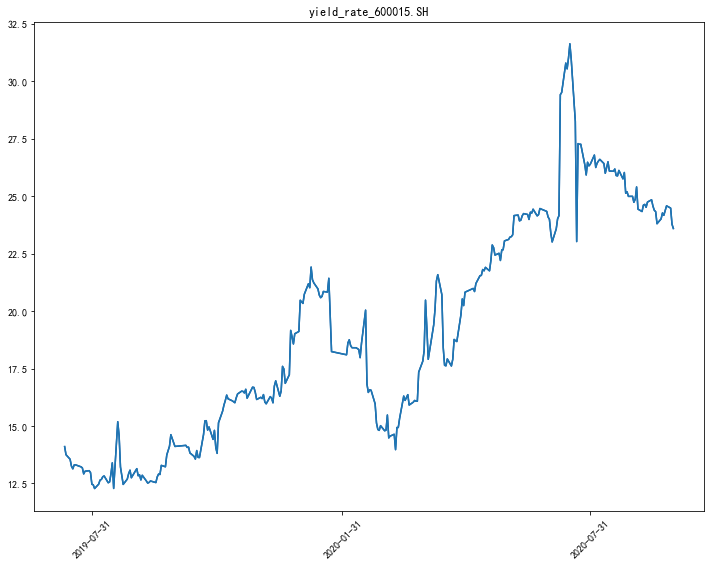

In [5]:
gundong.plot(gundong.column_list[1])

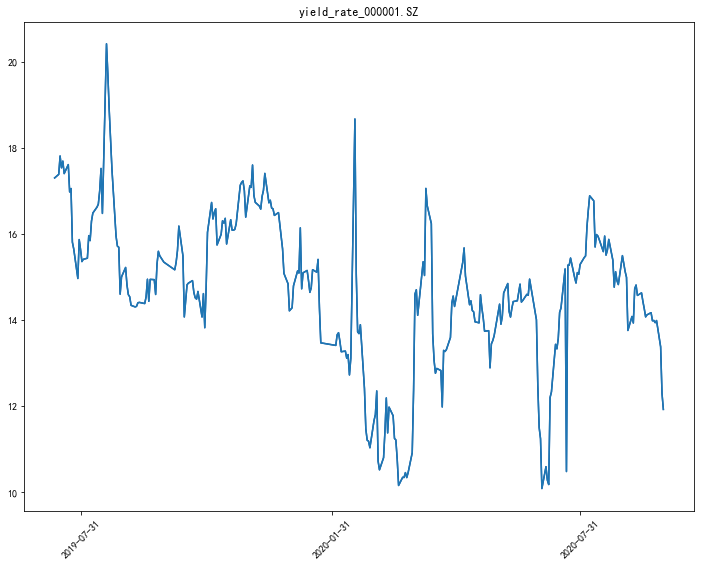

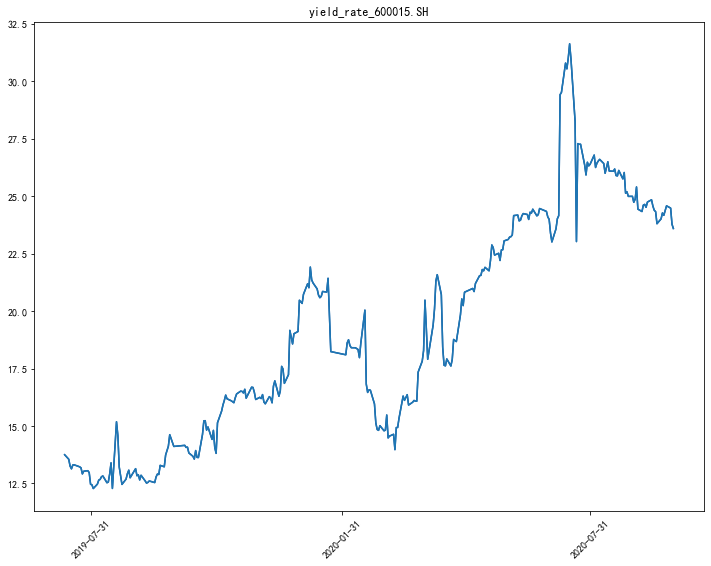

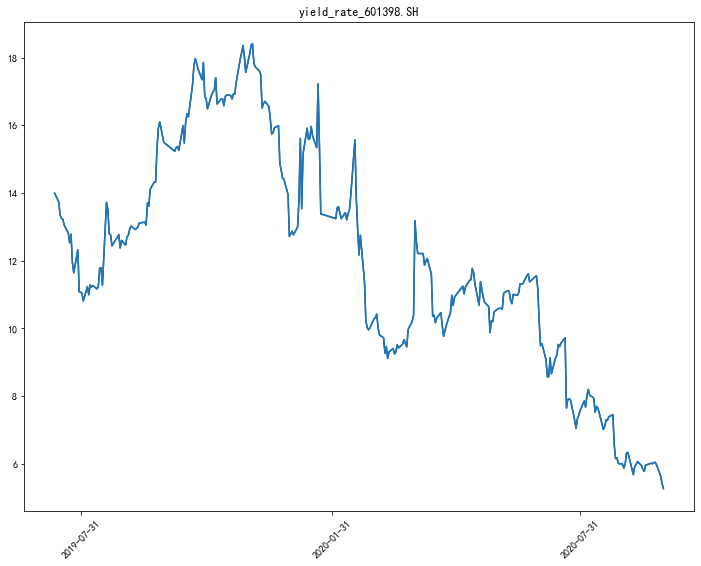

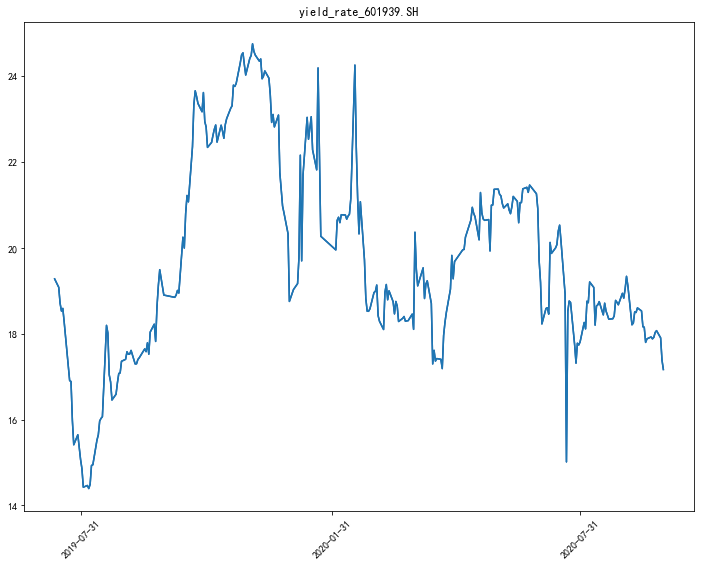

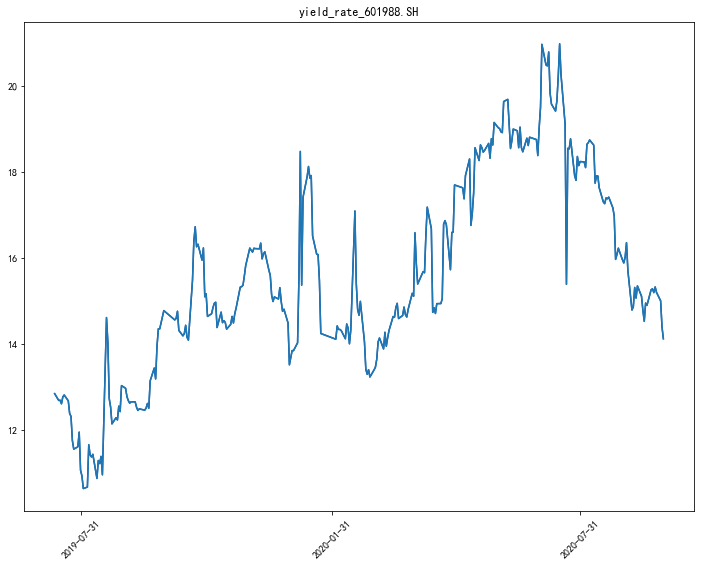

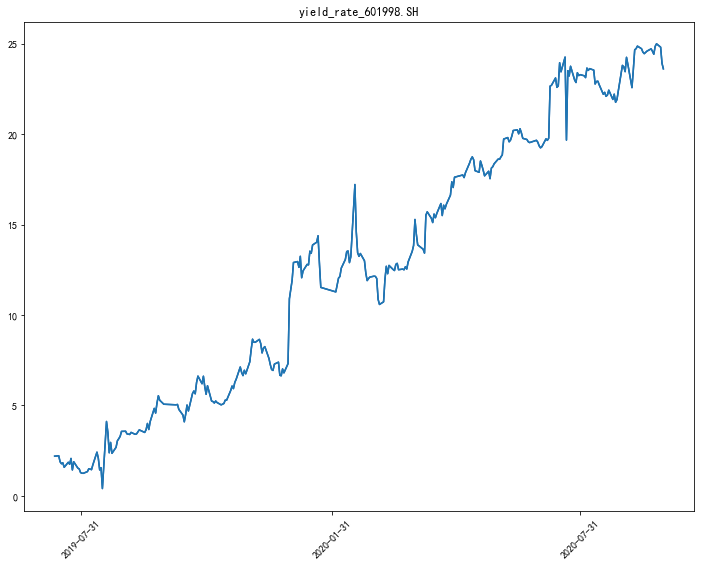

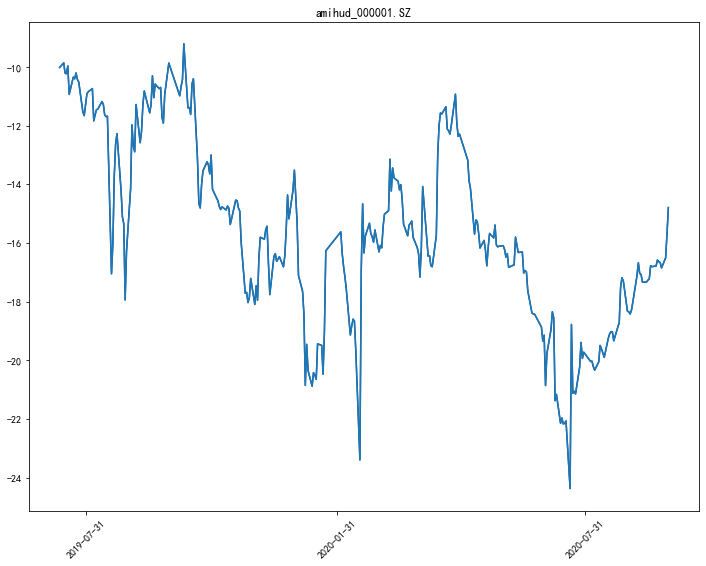

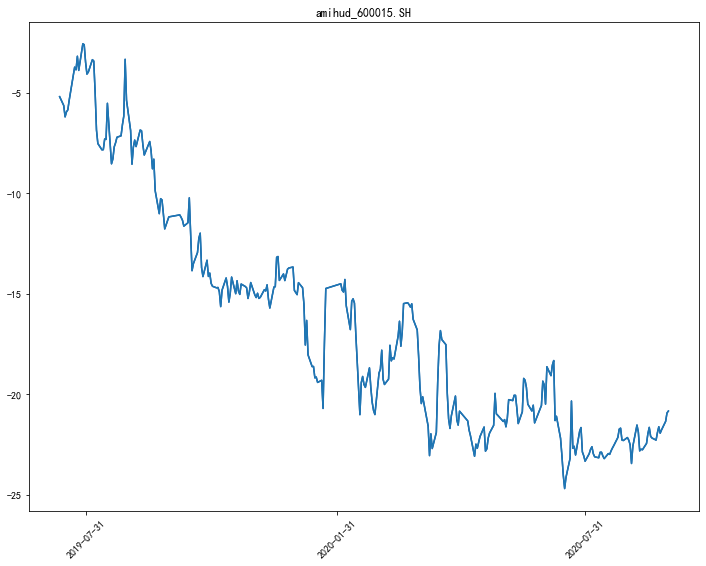

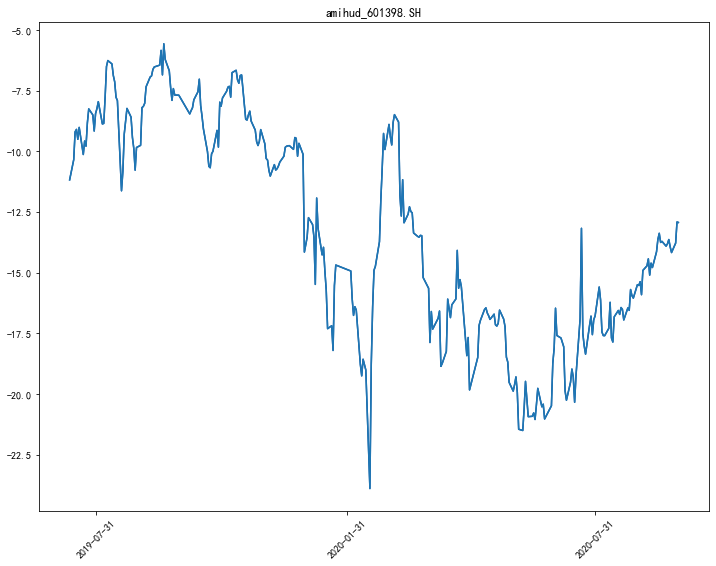

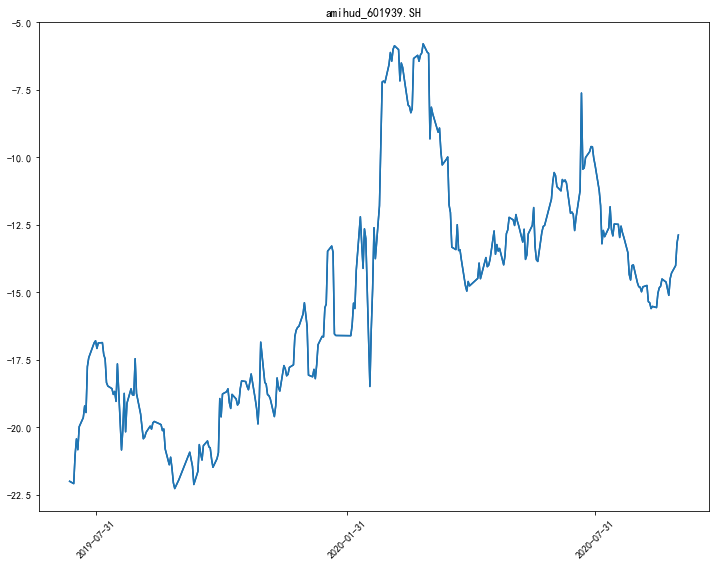

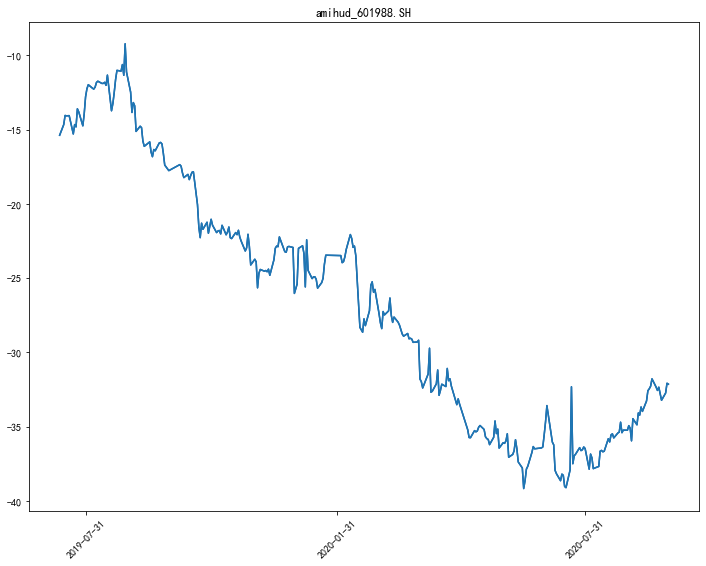

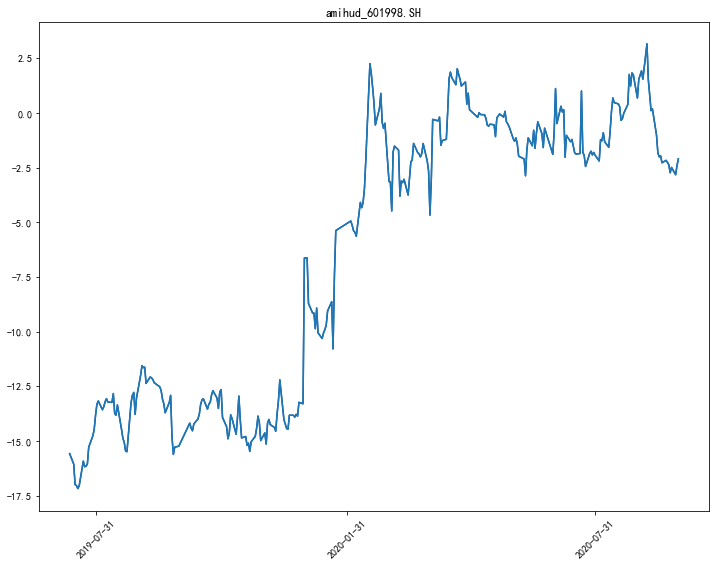

In [22]:
for i in gundong.column_list:
    gundong.plot_bianji(i)

In [8]:
temp=np.arange(12)
temp

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [12]:
temp[0:temp.shape[0]]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [11]:
temp.shape

(12,)

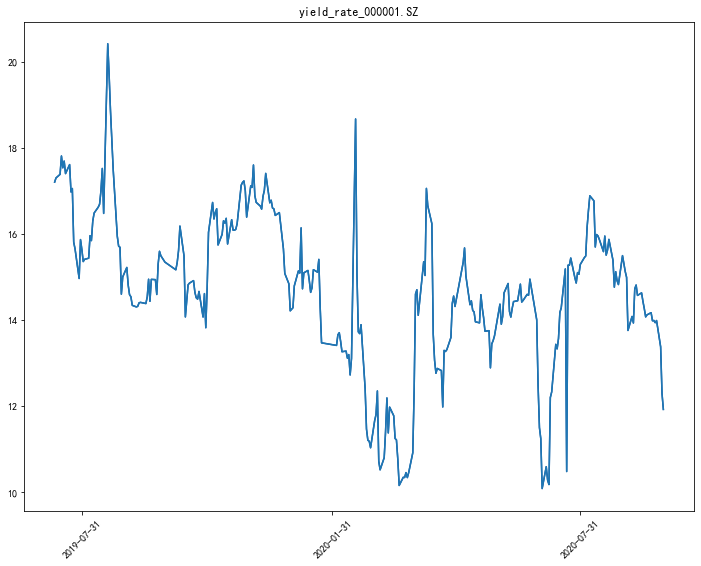

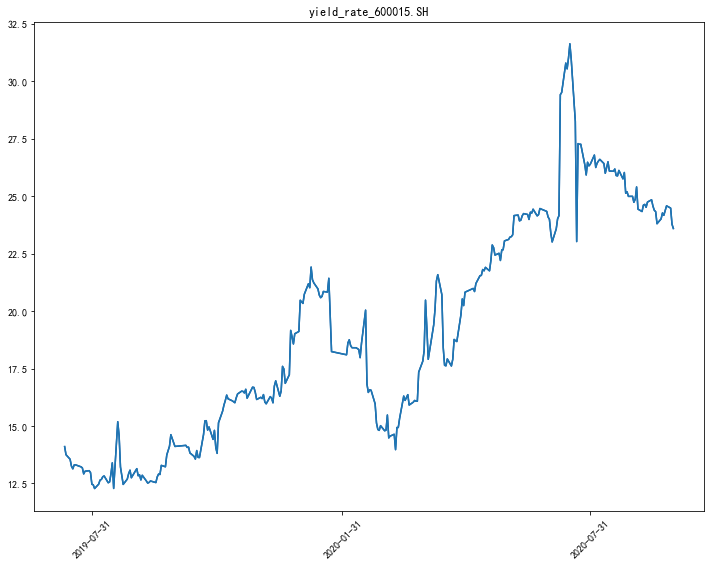

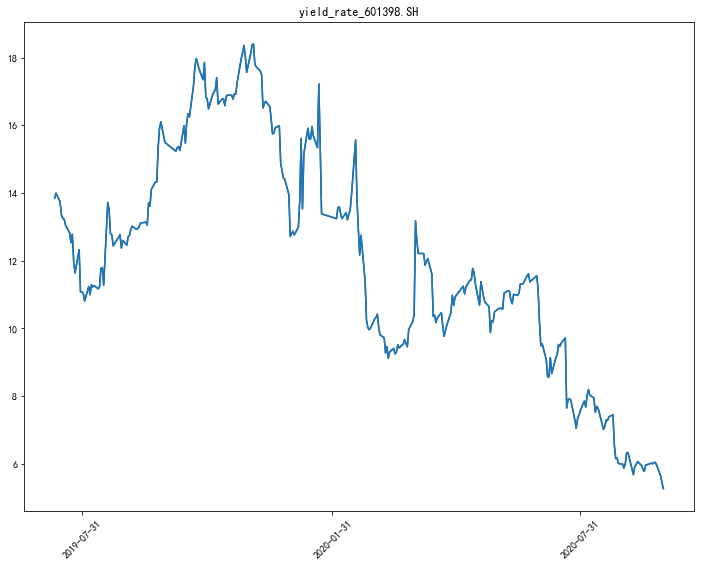

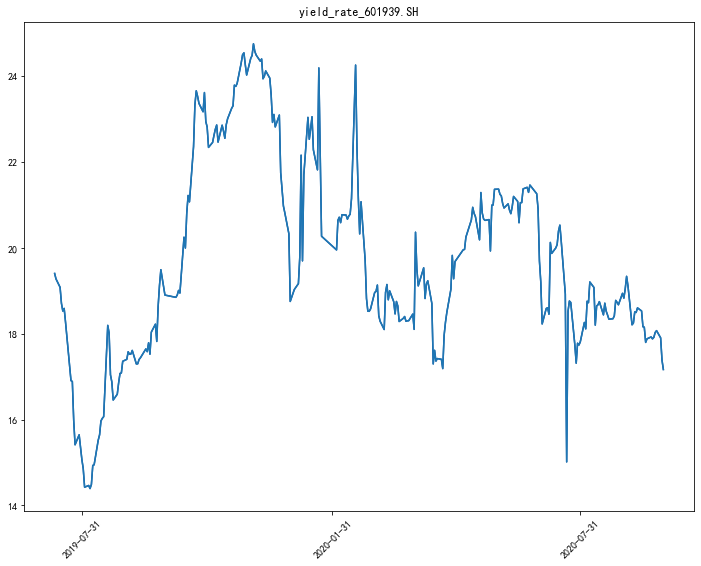

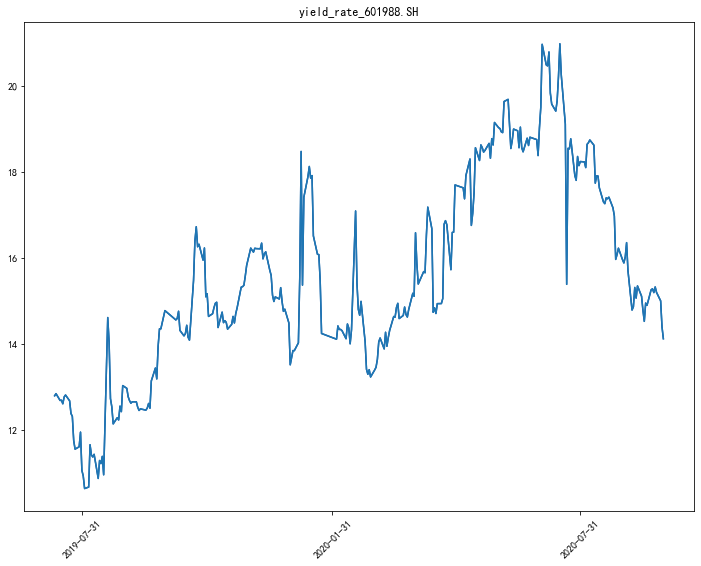

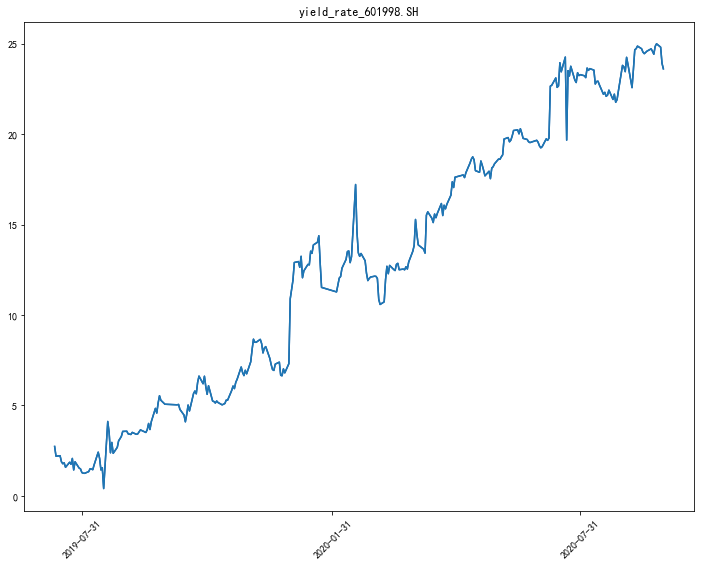

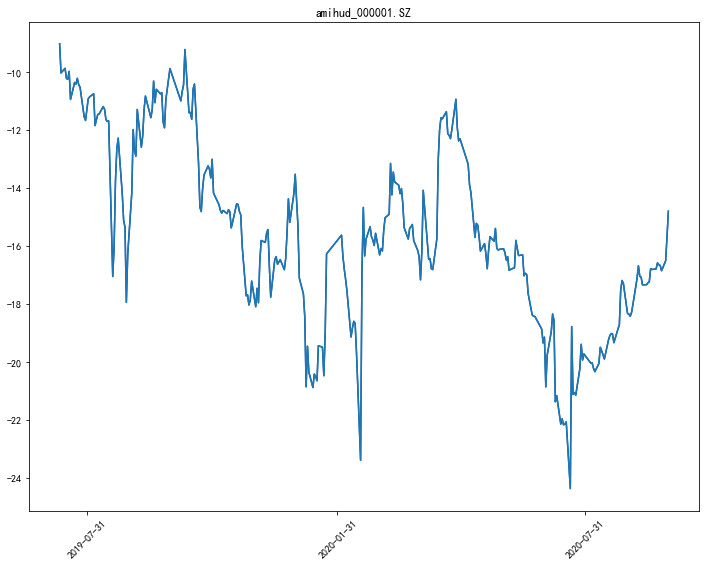

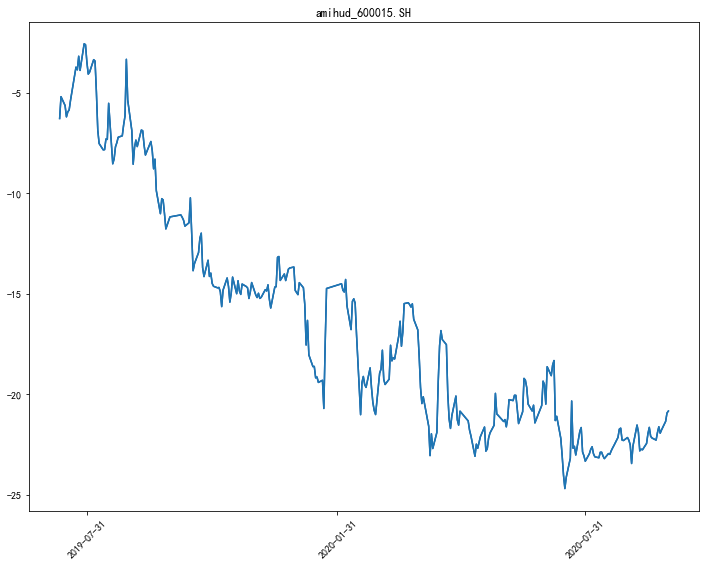

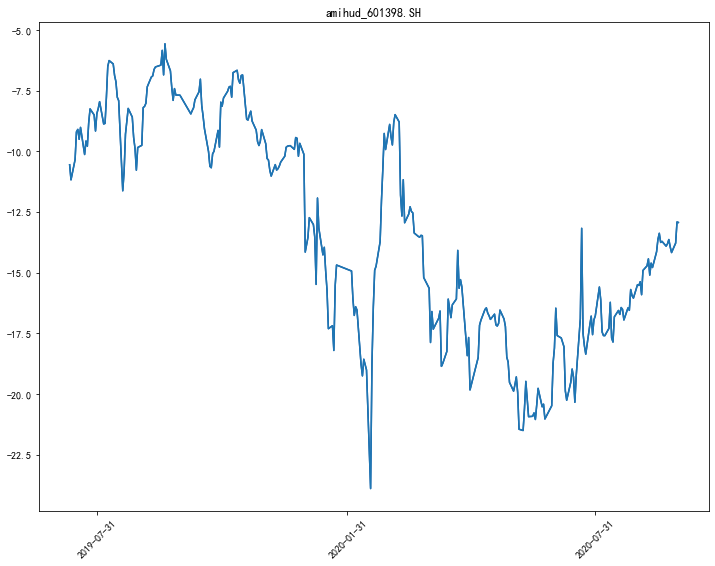

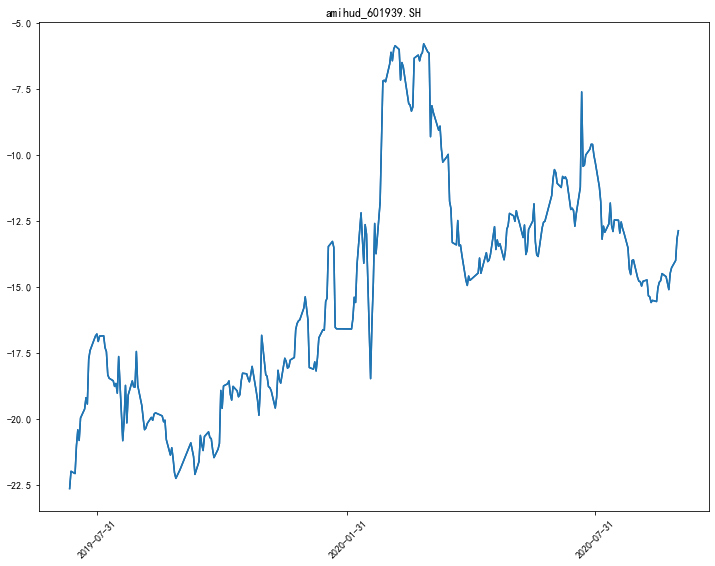

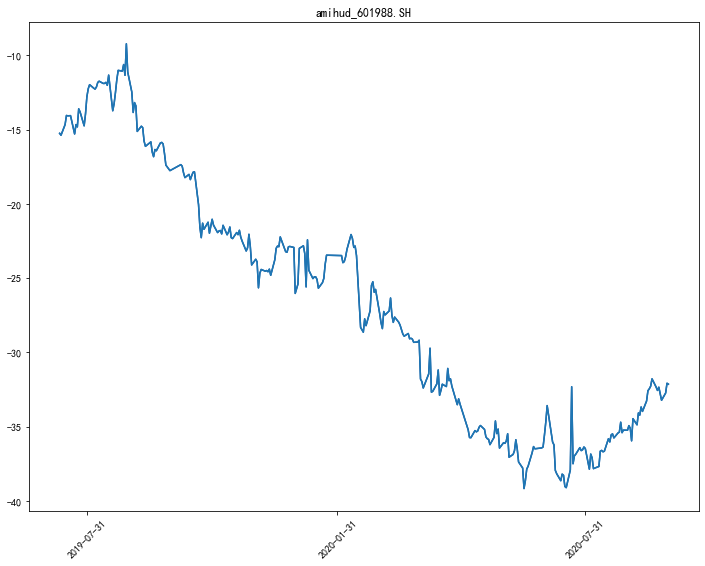

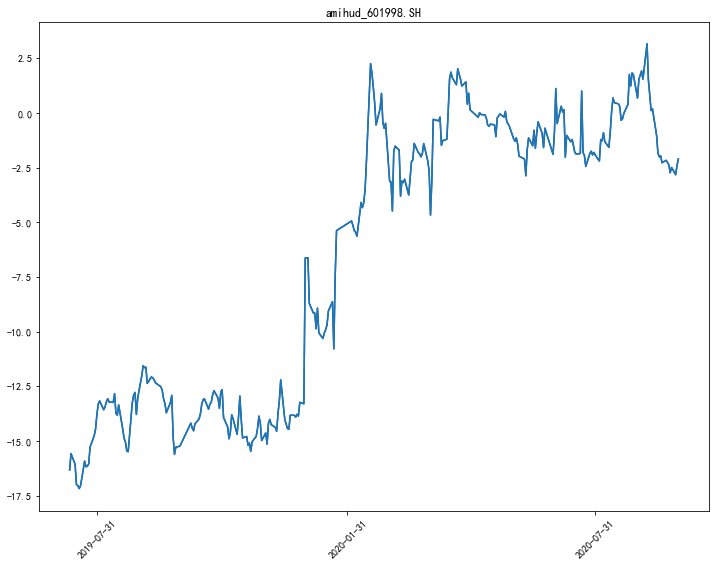

In [23]:
for i in gundong.column_list:
    gundong.plot(i)